# Basic spectrogram image classification with Basic Audio Data Augmentation

Code modified from JUN KODA's [Basic spectrogram image classification](https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification).
In addition, @myso1987 introduced some basic audio data augmentations.

In [ ]:
import datetime
print("開始時間： ", datetime.datetime.now() + datetime.timedelta(hours=9))

開始時間：  2022-12-30 00:57:44.369584


In [ ]:
# !mkdir -p /content/input/g2net-detecting-continuous-gravitational-waves

In [ ]:
!nvidia-smi

Thu Dec 29 15:57:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    53W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import sys
from pathlib import Path
import os
import json

if 'google.colab' in sys.modules:  # colab環境
    # INPUT = Path(‘/content/input/’)
    print('google colaboratory環境です！')
    # if not os.path.exists('/content/train.csv'):
    if not os.path.exists('/content/input'):
        !pip install kaggle
        from google.colab import drive
        drive.mount('/content/drive')

        f = open("/content/drive/MyDrive/kaggle.json", 'r')
        json_data = json.load(f) 
        os.environ['KAGGLE_USERNAME'] = json_data['username']
        os.environ['KAGGLE_KEY'] = json_data['key']


        # 生成したデータセットを使用
        # !kaggle datasets download -d naokimizutani/part44-h0-1-10-4000-mean-normalized-dataset -p '/content/input' --unzip
        !kaggle datasets download -d naokimizutani/low-snr-ver4-h0-50-snr17to80 -p '/content/input' --unzip


        # trainデータセットをダウンロード  
        !kaggle datasets download -d naokimizutani/g2net-train-data-for-colab -p '/content/input' --unzip
        # !kaggle datasets download -d naokimizutani/light-g2net-train-data-for-colab -p '/content/input' --unzip
        
        


    # このノートブック名を取得
    # from requests import get
    # name_notebook = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

elif 'kaggle_web_client' in sys.modules:  # kaggle環境
    print('kaggle環境です！')
    # INPUT = Path(‘../input/’)
    pass

google colaboratory環境です！
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive
100% 2.33G/2.33G [02:05<00:00, 23.2MB/s]
100% 2.33G/2.33G [02:05<00:00, 20.0MB/s]
100% 13.7G/13.7G [12:38<00:00, 19.6MB/s]
100% 13.7G/13.7G [12:38<00:00, 19.5MB/s]


In [ ]:
! pip install timm -q
# ! pip install git+https://github.com/mapillary/inplace_abn.git@v1.0.12
! pip install ipdb

     |████████████████████████████████| 549 kB 27.1 MB/s 
     |████████████████████████████████| 182 kB 67 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 761 kB 31.8 MB/s 
     |████████████████████████████████| 1.6 MB 59.2 MB/s 
     |████████████████████████████████| 386 kB 82.5 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 2.0.10
    Uninstalling prompt-toolkit-2.0.10:
      Successfully uninstalled prompt-toolkit-2.0.10
  Attempting uninstall: ipython
    Found existing installation: ipython 7.9.0
    Uninstalling ipython-7.9.0:
      Successfully uninstalled ipython-7.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 8.7.0 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, gc, sys
import h5py
import timm
import torch
import torch.nn as nn
import torchaudio
import torchvision.transforms as TF
import torch.nn.functional as F

import os
import random
from ipdb import set_trace as st

from tqdm.auto import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from timm.scheduler import CosineLRScheduler

# device = torch.device('cuda')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.BCEWithLogitsLoss()

gc.collect()
torch.cuda.empty_cache()

# Train metadata
di = '../input/g2net-detecting-continuous-gravitational-waves'

di = '/content/input'
df = pd.read_csv(di + '/train_labels.csv')
df = df[df.target >= 0]  # Remove 3 unknowns (target = -1)

train_len = df.shape[0]

In [ ]:
device

'cuda'

# Config

In [ ]:
# model_name = 'tf_efficientnet_b7'
# model_name = 'tf_efficientnet_b7_ns'
# model_name = 'tf_efficientnet_b6_ns'
# model_name = 'tf_efficientnet_b5_ns'
# model_name = 'tf_efficientnet_b4_ns'
# model_name = 'tf_efficientnet_b2_ns'
model_name = 'tf_efficientnet_b1_ns'

# model_name = 'tresnet_xl_448'
# model_name = 'tresnet_m'
# model_name = 'resnext50_32x4d'

# model_name = 'tf_efficientnet_l2_ns'
# model_name = 'tf_efficientnet_l2_ns_475'

# model_name = 'swinv2_base_window12to24_192to384_22kft1k'

# model_name = 'tf_efficientnet_b8'
# model_name = 'tf_efficientnet_b2_ns'

IMG_SIZE = None
# IMG_SIZE = 384
# IMG_SIZE = (384, 128) # transformer系は縦横決められたサイズに変換しないといけない。

fc_dim=512

N_FOLD = 5
SINGLE_KFOLD = False
# epochs = 25
epochs = 20

batch_size = 16

num_workers = 2
weight_decay = 1e-6
lr_max = 4e-4
epochs_warmup = 1.0
# max_grad_norm = 1000
max_grad_norm = 10



## setting of audio data augmentation 
flip_rate = 0.6 # probability of applying the horizontal flip and vertical flip'(水平フリップと垂直フリップの適用確率 ) 
fre_shift_rate = 0.6 # probability of applying the vertical shift(垂直方向シフトの適用確率)

time_mask_num = 3 # number of time masking(タイムマスキング数)
time_mask_param_num = 5
# time_mask_num = 2
# time_mask_param_num = 10

freq_mask_num = 3 # number of frequency masking(周波数マスキング数)
freq_mask_param_num = 5
# freq_mask_num = 2
# freq_mask_param_num = 10



# ver_title = "b7 mask freq2 param10 5fold"
# ver_title = "b7 mask freq3 param5 5fold"
# ver_title = "nonsb7 mask freq2 param10 5fold"
# ver_title = "esnext50-32x4d mask fr3pa5 5fold"
# ver_title = "tf_effi_l2_ns_475 fr3pa5 5fold"
# ver_title = "tf_effi_l2_ns fr3pa5 5fold"
# ver_title = "swinv2_base fr3pa5 5fold"
# ver_title = "nonsb8 fr3pa5 5fold"
# ver_title = "b2 fr3pa5 5fold"
# ver_title = "b7 gen1-10 4000 no10 0.996 5fold"
# ver_title = "b7 gen1-10 4000 no10 0.993 5fold"
# ver_title = "b7 snr41 4000 no10 5fold"
ver_title = "b1 snr41 4000 no10 5fold"

batch_size = 32

# upload_dataset_name = "b7-g2net-train-model"
# upload_dataset_name = "b7-mask-freq3-param5-5fold-g2net-train-model"
# upload_dataset_name = "nonsb7-mask-freq3-param5-5fold-g2net-train-model"
# upload_dataset_name = "esnext50-32x4d-g2net-dataset"
# upload_dataset_name = "tf-efficientnet-l2-ns-g2net-dataset"
# upload_dataset_name = "swinv2-base-window12to24-192to384-22kft1k-dataset"
# upload_dataset_name = "nonsb8-dataset"
# upload_dataset_name = "b2-dataset"
# upload_dataset_name = "b7-gen1-10-4000-no10-966-model"
# upload_dataset_name = "b7-snr41-4000-no10-model"
upload_dataset_name = "b1-snr41-4000-no10-model"

# seed

In [ ]:
def seed_everything(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(seed=42)

# LOGGER

In [ ]:
OUTPUT_DIR = f"/content/{(datetime.datetime.now() + datetime.timedelta(hours=9)).strftime('%Y%m%d-%H%M%S')}"
!mkdir -p $OUTPUT_DIR

def get_logger(filename = "training"):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    # fileHandler = FileHandler(f'/{OUTPUT_DIR}/{filename}.log')
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter('%(message)s'))
    # handler2 = FileHandler(filename = f'{filename}.log')
    handler2 = FileHandler(filename = f'{OUTPUT_DIR}/{filename}.log')
    handler2.setFormatter(Formatter('%(message)s'))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

# Dataset

In [ ]:
# def img_clipping(x, p=3, standard=256):
#     point = np.percentile(x, 100-p)
#     imgo = ((standard//2)*(x-x.min())/(point-x.min()))
#     imgo = np.clip(imgo, 0, standard)
#     return imgo.astype(np.float32)

In [ ]:
DIR = '/content/input/0_data'
zero_data_len = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])

DIR = '/content/input/1_data'
one_data_len = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])

total_data = zero_data_len + one_data_len
total_df = pd.DataFrame(np.arange(total_data), columns=['id'])
total_df['signal_exist'] = 0
total_df.iloc[:one_data_len]['signal_exist'] = 1

print("one_data_len: ", one_data_len)
print("zero_data_len: ", zero_data_len)
print("total_data: ", total_data)
total_df

one_data_len:  4000
zero_data_len:  4000
total_data:  8000


<ipython-input-12-5427e97abb07>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df.iloc[:one_data_len]['signal_exist'] = 1


,id,signal_exist
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
7995,7995,0
7996,7996,0
7997,7997,0
7998,7998,0


In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tfms=False):
        self.df = df
        self.tfms = tfms

    def __len__(self):
        return len(self.df)
        # return total_df

    def __getitem__(self, i):

        # print("length: ", len(self.df)) -> 6400(8000の4/5)
        # iには0〜6399までの数字がシャッフルな順番で回ってくる（stratifiedで均等に分割されて）。
        row = self.df.iloc[i]
        
        # row.idがポジティブな画像の総枚数未満かどうか
        if row.id < one_data_len:
            # img, y = self.get_positive(i)

            # file_name = f'/content/input/1_data/signals_{i}.npy'
            file_name = f'/content/input/1_data/signals_{row.id}.npy'

            img = np.load(file_name).astype(np.float64)


            # # ポジティブ（signal入り）な画像はネガティブ(signalなし)な画像をノイズとして合成する
            # #==========================================================
            # noise_id = int(random.random() * zero_data_len)
            # # noise_r = random.random()*0.05+0.95
            # # noise_r = random.random()*0.005+0.995 # 0.994くらいまでは視覚でわかる感じ。0.996からは肉眼でも難しいかなレベル。
            # # noise_r = random.random()*0.004 +0.996
            # noise_r = random.random()*0.007 +0.993
            # # noise_r = 0.995

            # neg_file_name = f'/content/input/0_data/signals_{noise_id + one_data_len}.npy'
            # neg_img = np.load(neg_file_name).astype(np.float64)

            # # img = (np.sqrt(img)*(1-noise_r)+np.sqrt(self.get_negative(noise_id)[0])*noise_r)**2
            # img = (np.sqrt(img)*(1-noise_r)+np.sqrt(neg_img)*noise_r)**2
            # #==========================================================


            y=1.0
        else:
            # img, y = self.get_negative(i)

            # file_name = f'/content/input/0_data/signals_{i}.npy'

            file_name = f'/content/input/0_data/signals_{row.id}.npy'


            img = np.load(file_name).astype(np.float64)
            y=0.0


        # ポジティブな画像はネガティブな画像とノイズ合成を行っており、分布がずれているのでnormalizeする。
        # （ネガティブな画像にnormalizeする必要はないが、すでにnormalizeされている画像に再度normalizeしても分布に変化はないため、ここで一括でnormalizeを入れている）
        img = ((img)/img.mean() ).astype(np.float32)

        if self.tfms:
            if np.random.rand() <= flip_rate: # horizontal flip
                img = np.flip(img, axis=1).copy()
            if np.random.rand() <= flip_rate: # vertical flip
                img = np.flip(img, axis=2).copy()
            if np.random.rand() <= fre_shift_rate: # vertical shift
                img = np.roll(img, np.random.randint(low=0, high=img.shape[1]), axis=1)
            
            img = torch.from_numpy(img)

            for _ in range(time_mask_num): # tima masking
                img = transforms_time_mask(img)
            for _ in range(freq_mask_num): # frequency masking
                img = transforms_freq_mask(img)
        
        # else:
        #     img = torch.from_numpy(img)
                
        return img, y



class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_type, df, tfms=False):
        self.data_type = data_type
        self.df = df
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        r = self.df.iloc[i]
        y = np.float32(r.target)
        file_id = r.id

        img = np.empty((2, 360, 128), dtype=np.float32)

        filename = '%s/%s/%s.hdf5' % (di, self.data_type, file_id)
        with h5py.File(filename, 'r') as f:
            g = f[file_id]
            
            for ch, s in enumerate(['H1', 'L1']):
                a = g[s]['SFTs'][:, :4096] * 1e22  # Fourier coefficient complex64
                p = a.real**2 + a.imag**2  # power
                p /= np.mean(p)  # normalize TODO: 元はnp.map(p)だった。違いを検証！！！！！！！
                p = np.mean(p.reshape(360, 128, 32), axis=2)  # compress 4096 -> 128
                img[ch] = p

        if self.tfms:
            if np.random.rand() <= flip_rate: # horizontal flip
                img = np.flip(img, axis=1).copy()
            if np.random.rand() <= flip_rate: # vertical flip
                img = np.flip(img, axis=2).copy()
            if np.random.rand() <= fre_shift_rate: # vertical shift
                img = np.roll(img, np.random.randint(low=0, high=img.shape[1]), axis=1)
            
            img = torch.from_numpy(img)

            for _ in range(time_mask_num): # tima masking
                img = transforms_time_mask(img)
            for _ in range(freq_mask_num): # frequency masking
                img = transforms_freq_mask(img)
        
        else:
            img = torch.from_numpy(img)
                
        return img, y


# class Dataset(torch.utils.data.Dataset):
#     """
#     dataset = Dataset(data_type, df)

#     img, y = dataset[i]
#       img (np.float32): 2 x 360 x 128
#       y (np.float32): label 0 or 1
#     """
#     # def __init__(self, data_type, df, tfms=False):
#     #     self.data_type = data_type
#     #     self.df = df
#     #     self.tfms = tfms
#     def __init__(self, file_id=None, tfms=False):
#         self.file_id = file_id
#         self.tfms = tfms

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, i):
#         """
#         i (int): get ith data
#         """

#         img = np.empty((2, 360, 128), dtype=np.float32)

#         y = 1.0 if self.file_id == "001121a05" else 0
#         filename = f"/content/drive/MyDrive/g2net_train_sample/{self.file_id}.hdf5"
#         with h5py.File(filename, 'r') as f:
#             g = f[self.file_id]
            
#             for ch, s in enumerate(['H1', 'L1']):
#                 a = g[s]['SFTs'][:, :4096] * 1e22  # Fourier coefficient complex64
#                 p = a.real**2 + a.imag**2  # power
#                 p /= np.mean(p)  # normalize TODO: 元はnp.map(p)だった。違いを検証！！！！！！！
#                 p = np.mean(p.reshape(360, 128, 32), axis=2)  # compress 4096 -> 128
#                 img[ch] = p

#         if self.tfms:
#             if np.random.rand() <= flip_rate: # horizontal flip
#                 img = np.flip(img, axis=1).copy()
#             if np.random.rand() <= flip_rate: # vertical flip
#                 img = np.flip(img, axis=2).copy()
#             if np.random.rand() <= fre_shift_rate: # vertical shift
#                 img = np.roll(img, np.random.randint(low=0, high=img.shape[1]), axis=1)
            
#             img = torch.from_numpy(img)

#             for _ in range(time_mask_num): # tima masking
#                 img = transforms_time_mask(img)
#             for _ in range(freq_mask_num): # frequency masking
#                 img = transforms_freq_mask(img)
        
#         else:
#             img = torch.from_numpy(img)
                
        # return img, y

In [ ]:
# random.random()*0.004+0.994

# Audio Data Augmentation

* horizontal flip
* vertical flip
* vertical shift
* time masking*
* frequency masking*

*Reference  
SpecAugment  
https://arxiv.org/abs/1904.08779

# マスク

In [ ]:
# データオーギュメント

# 時間方向にスペクトラムをマスクする
transforms_time_mask = nn.Sequential(
                torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param_num),
            )

# 時間方向にスペクトラムをマスクする
transforms_freq_mask = nn.Sequential(
                torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param_num),
            )

In [ ]:
# dataset = Dataset(file_id="001121a05", tfms=False)
# img_real_1, y = dataset[0]
# dataset = Dataset(file_id="01bcf6533", tfms=False)
# img_real_0, y = dataset[0]

dataset = Dataset('train', df)
img_real_0, y = dataset[0]
img_real_1, y = dataset[1]


# dataset = CustomDataset()
dataset = CustomDataset(total_df, tfms=True)
# img_label0_1, y = dataset[10050]
# img_label0_2, y = dataset[10051]
img_label0_1, y = dataset[one_data_len + 100]
img_label0_2, y = dataset[one_data_len  + 101]

# img_label1_1, y = dataset[0]
# img_label1_2, y = dataset[1]
img_label1_1, y = dataset[0]
img_label1_2, y = dataset[1]

In [ ]:
img_real_0.shape, img_label0_1.shape, img_label0_2.shape

(torch.Size([2, 360, 128]),
 torch.Size([2, 360, 128]),
 torch.Size([2, 360, 128]))

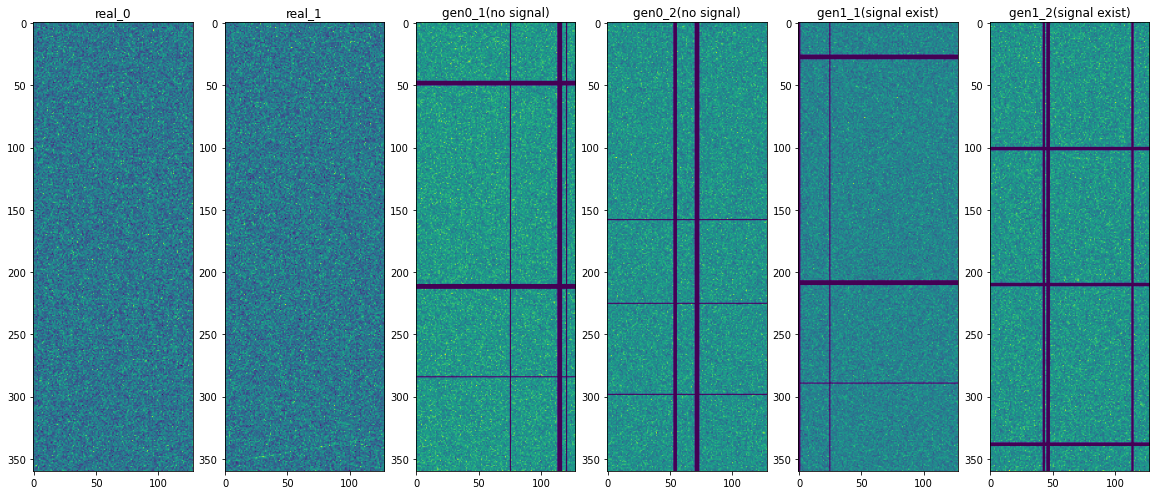

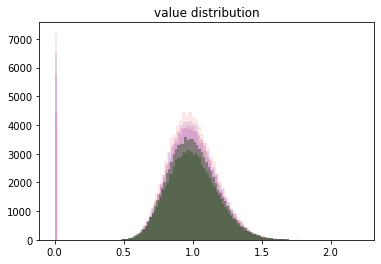

In [ ]:
fig, ax = plt.subplots(1,6, figsize=(20, 46))
plt.title('generated image')
ax[0].set(title=f"real")
ax[0].set(title=f"real_0")
ax[1].set(title=f"real_1")
ax[2].set(title=f"gen0_1(no signal)")
ax[3].set(title=f"gen0_2(no signal)")
ax[4].set(title=f"gen1_1(signal exist)")
ax[5].set(title=f"gen1_2(signal exist)")

c0 = ax[0].imshow(img_real_0[0])
c1 = ax[1].imshow(img_real_1[0])
c2 = ax[2].imshow(img_label0_1[0])
c3 = ax[3].imshow(img_label0_2[0])
c4 = ax[4].imshow(img_label1_1[0])
c5 = ax[5].imshow(img_label1_2[0])

# fig.colorbar(c0, ax=ax[0])
# fig.colorbar(c1, ax=ax[1])
# fig.colorbar(c2, ax=ax[2])
# fig.colorbar(c3, ax=ax[3])

plt.show()

plt.title('value distribution')
plt.hist(img_real_0.flatten(),bins=100,alpha=0.5,color='g')
plt.hist(img_real_1.flatten(),bins=100,alpha=0.5,color='g')
plt.hist(img_label0_1.flatten(),bins=100,alpha=0.1,color='b')
plt.hist(img_label0_2.flatten(),bins=100,alpha=0.1,color='b')
plt.hist(img_label1_1.flatten(),bins=100,alpha=0.1,color='r')
plt.hist(img_label1_2.flatten(),bins=100,alpha=0.1,color='r')
plt.show()

# Model

In [ ]:
class Model(nn.Module):
    def __init__(self, name, *, pretrained=False):
        """
        name (str): timm model name, e.g. tf_efficientnet_b2_ns
        """
        super().__init__()

        # name = 'tf_efficientnet_b7_ns'
        # name = 'resnext50_32x4d'

        # Use timm
        # model = timm.create_model(name, pretrained=pretrained, in_chans=2, num_classes=1) # in_chansで入力チャンネルを設定できる。今回はH1とL1の２枚の画像があるからin_chans=2を指定。
        model = timm.create_model(name, pretrained=pretrained, in_chans=2)
        # model = timm.create_model(MODEL, pretrained=True, num_classes=1, in_chans=2, drop_rate=DROPOUT).to(DEVICE)

        # clsf = model.default_cfg['classifier'] # model.default_cfg['classifier']で"classifier"という文字列を取得。（多分efficientnetは画像分類がデフォルトの設定のため）
        # n_features = model._modules[clsf].in_features # model._modules[clsf](model._modules["classifier"])で最終層取得。in_featuresは最終層に渡される特徴数。(1408)
        # model._modules[clsf] = nn.Identity() # in_featuresの数(1408)だけ取得しておいて、デフォルトの最終層はnn.Identity()に置き換えることで無効化することができる。

        if name[:15] == 'tf_efficientnet':
            clsf = model.default_cfg['classifier'] # model.default_cfg['classifier']で"classifier"という文字列を取得。（多分efficientnetは画像分類がデフォルトの設定のため）
            n_features = model._modules[clsf].in_features # model._modules[clsf](model._modules["classifier"])で最終層取得。in_featuresは最終層に渡される特徴数。(1408)
            model._modules[clsf] = nn.Identity() # in_featuresの数(1408)だけ取得しておいて、デフォルトの最終層はnn.Identity()に置き換えることで無効化することができる。

        elif name == 'tresnet_m':
            n_features = model.head.fc.in_features
            model.head.fc = nn.Linear(n_features, fc_dim)

        elif name == 'resnext50_32x4d':
            n_features = model.fc.in_features
            model.fc = nn.Linear(n_features, fc_dim)

        elif name.split('_')[0] == 'swinv2':
            n_features = model.head.in_features
            model.head = nn.Identity()


        # if name[:9] == 'eca_nfnet':
        #     clsf = 'head'
        #     n_features = model._modules['head'].fc.in_features
        #     model._modules[clsf].fc = nn.Identity()
        # elif name[:15] == 'tf_efficientnet':
        #     clsf = model.default_cfg['classifier']
        #     n_features = model._modules[clsf].in_features
        #     model._modules[clsf] = nn.Identity()
        # else:
    

        # n_features = model._modules['head'].fc.in_features
        # model._modules['head'].fc = nn.Identity()

        # ('global_pool',
        # SelectAdaptivePool2d (pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))),
        # ('classifier',
        # Linear(in_features=1408, out_features=1000, bias=True))])

        if name[:15] == 'tf_efficientnet':
            self.fc = nn.Linear(n_features, 1) # in_features(1408)の特徴を元に、回帰して最終的なシグナルが存在する確率を出す。
        elif name == 'tresnet_m':
            self.fc = nn.Linear(fc_dim, 1)
        elif name == 'resnext50_32x4d':
            self.fc = nn.Linear(fc_dim, 1)
        elif name.split('_')[0] == 'swinv2':
            self.fc = nn.Linear(n_features, 1)

        self.model = model

    def forward(self, x):
        # if IMG_SIZE:
        #     x = F.interpolate(x, IMG_SIZE)

        x = self.model(x)
        x = self.fc(x)
        return x

# Predict and evaluate

In [ ]:
def evaluate(model, loader_val, *, compute_score=True, pbar=None):
    """
    Predict and compute loss and score
    """
    tb = time.time()
    was_training = model.training
    model.eval()

    loss_sum = 0.0
    n_sum = 0
    y_all = []
    y_pred_all = []

    if pbar is not None:
        pbar = tqdm(desc='Predict', nrows=78, total=pbar)

    for img, y in loader_val:
        n = y.size(0)
        img = img.to(device)
        y = y.to(device)

        with torch.no_grad():
                y_pred = model(img.to(device))

        loss = criterion(y_pred.view(-1), y)

        n_sum += n
        loss_sum += n * loss.item()

        y_all.append(y.cpu().detach().numpy())
        y_pred_all.append(y_pred.sigmoid().squeeze().cpu().detach().numpy())

        if pbar is not None:
            pbar.update(len(img))
        
        del loss, y_pred, img, y

    loss_val = loss_sum / n_sum

    y = np.concatenate(y_all)
    y_pred = np.concatenate(y_pred_all)

    score = roc_auc_score(y, y_pred) if compute_score else None

    ret = {'loss': loss_val,
           'score': score,
           'y': y,
           'y_pred': y_pred,
           'time': time.time() - tb}
    
    model.train(was_training)  # back to train from eval if necessary
    gc.collect()

    return ret

# Train

In [ ]:
gen_oof_df = pd.DataFrame(0, index=np.arange(total_data), columns=["y", "y_pred", "fold"])

In [ ]:
%%time

# kfold = KFold(n_splits=N_FOLD, random_state=42, shuffle=True)
kfold = StratifiedKFold(n_splits=N_FOLD, random_state=42, shuffle=True)

best_score_list = []
best_val_loss_list = []
best_train_loss_list = []


# for ifold, (idx_train, idx_test) in enumerate(kfold.split(df)):
for ifold, (idx_train, idx_test) in enumerate(kfold.split(gen_oof_df, gen_oof_df.y)):
    print(f'Fold{ifold + 1}/{N_FOLD}')

    # dataset_train = Dataset('train', df.iloc[idx_train], tfms=True)
    # dataset_val = Dataset('train', df.iloc[idx_test])
    dataset_train = CustomDataset(total_df.iloc[idx_train], tfms=True)
    dataset_val = CustomDataset(total_df.iloc[idx_test])



    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                     num_workers=num_workers, pin_memory=True, shuffle=True, drop_last=True)
    loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size,
                     num_workers=num_workers, pin_memory=True)

    # Model and optimizer
    model = Model(model_name, pretrained=True)
    model.to(device)
    model.train()

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr_max, weight_decay=weight_decay)

    # Learning-rate schedule
    nbatch = len(loader_train)
    warmup = epochs_warmup * nbatch  # number of warmup steps
    nsteps = epochs * nbatch        # number of total steps

    scheduler = CosineLRScheduler(optimizer,
                  warmup_t=warmup, warmup_lr_init=0.0, warmup_prefix=True, # 1 epoch of warmup
                  t_initial=(nsteps - warmup), lr_min=1e-6)                # 3 epochs of cosine
    
    time_val = 0.0
    lrs = []

    tb = time.time()
    
    best_score = 0.0

    for iepoch in range(epochs):
        

        loss_sum = 0.0
        n_sum = 0

        # Train
        for ibatch, (img, y) in enumerate(loader_train):
            n = y.size(0)
            img = img.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            y_pred = model(img)
            loss = criterion(y_pred.view(-1), y)

            loss_train = loss.item()
            loss_sum += n * loss_train
            n_sum += n

            loss.backward()

            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                       max_grad_norm)
            optimizer.step()
            
            scheduler.step(iepoch * nbatch + ibatch + 1)
            lrs.append(optimizer.param_groups[0]['lr'])            

        # Evaluate
        val = evaluate(model, loader_val)
        time_val += val['time']
        loss_train = loss_sum / n_sum
        lr_now = optimizer.param_groups[0]['lr']
        dt = (time.time() - tb) / 60
        print('Epoch %d train_loss %.4f val_loss %.4f auc %.4f  lr %.2e  %.2f min' %
              (iepoch + 1, loss_train, val['loss'], val['score'], lr_now, dt))
       
        # AUCがベストを更新したらモデルを保存
        if val['score'] > best_score:
            best_score = val['score']
            best_train_loss = loss_train
            best_val_loss = val['loss']
            
            # Save model
            ofilename = f'{OUTPUT_DIR}/model{ifold}.pytorch'
            torch.save(model.state_dict(), ofilename)
            print(f'Saved! Epoch {iepoch+1} - Save Best Score: {best_score:.6f} Model')

            # ベストなときのモデルが推測した値を持っておく。
            y_when_best = val['y']
            y_pred_when_best = val['y_pred']


    dt = time.time() - tb
    print('Training done %.2f min total, %.2f min val' % (dt / 60, time_val / 60))
    print('fold best LOSS:', best_val_loss)
    print('fold best SCORE:', best_score)
    LOGGER.info(f'fold best val SCORE: {best_score}, fold best val LOSS: {best_val_loss}')
        
    best_score_list.append(best_score)
    best_val_loss_list.append(best_val_loss)
    best_train_loss_list.append(best_train_loss)

    # foldのカラムは2番目
    gen_oof_df.iloc[idx_test, 2] = ifold
    # yのカラムは0番目
    gen_oof_df.iloc[idx_test, 0] = y_when_best
    if SINGLE_KFOLD:
        # y_predのカラムは1番目
        gen_oof_df.iloc[idx_test, 1] = y_pred_when_best
        break
    else:
        gen_oof_df.iloc[idx_test, 1] += y_pred_when_best / N_FOLD

gen_oof_df.to_pickle(f'{OUTPUT_DIR}/gen_oof_df.pkl', protocol = 4)
print("oof_df.pklを保存しました。")
print("##########################################################################")
print(f'CV: {np.mean(best_score_list)}, avg_val_loss: {np.mean(best_val_loss_list)}, avg_train_loss: {np.mean(best_train_loss_list)}')
print("##########################################################################")
LOGGER.info(f'CV: {np.mean(best_score_list)}, avg_val_loss: {np.mean(best_val_loss_list)}, avg_train_loss: {np.mean(best_train_loss_list)}, scores: {best_score_list}')

Fold1/5


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b1_ns-99dd0c41.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b1_ns-99dd0c41.pth


Epoch 1 train_loss 0.6952 val_loss 0.6755 auc 0.6023  lr 4.00e-04  0.56 min
Saved! Epoch 1 - Save Best Score: 0.602317 Model
Epoch 2 train_loss 0.6593 val_loss 0.6810 auc 0.6384  lr 3.97e-04  0.96 min
Saved! Epoch 2 - Save Best Score: 0.638369 Model
Epoch 3 train_loss 0.6274 val_loss 0.5996 auc 0.6889  lr 3.89e-04  1.35 min
Saved! Epoch 3 - Save Best Score: 0.688915 Model
Epoch 4 train_loss 0.6130 val_loss 0.5963 auc 0.6907  lr 3.76e-04  1.75 min
Saved! Epoch 4 - Save Best Score: 0.690686 Model
Epoch 5 train_loss 0.6025 val_loss 0.5922 auc 0.6801  lr 3.58e-04  2.14 min
Epoch 6 train_loss 0.6021 val_loss 0.5726 auc 0.7210  lr 3.36e-04  2.53 min
Saved! Epoch 6 - Save Best Score: 0.721019 Model
Epoch 7 train_loss 0.5917 val_loss 0.5857 auc 0.7207  lr 3.10e-04  2.93 min
Epoch 8 train_loss 0.5867 val_loss 0.5664 auc 0.7323  lr 2.81e-04  3.32 min
Saved! Epoch 8 - Save Best Score: 0.732267 Model
Epoch 9 train_loss 0.5793 val_loss 0.5614 auc 0.7341  lr 2.49e-04  3.72 min
Saved! Epoch 9 - Save 

fold best val SCORE: 0.7341334953280392, fold best val LOSS: 0.5613859462293391
INFO:__main__:fold best val SCORE: 0.7341334953280392, fold best val LOSS: 0.5613859462293391


Epoch 20 train_loss 0.5548 val_loss 0.5668 auc 0.7290  lr 1.00e-06  8.06 min
Training done 8.06 min total, 0.53 min val
fold best LOSS: 0.5613859462293391
fold best SCORE: 0.7341334953280392
Fold2/5
Epoch 1 train_loss 0.6939 val_loss 0.6675 auc 0.5780  lr 4.00e-04  0.40 min
Saved! Epoch 1 - Save Best Score: 0.577997 Model
Epoch 2 train_loss 0.6574 val_loss 0.6236 auc 0.6469  lr 3.97e-04  0.80 min
Saved! Epoch 2 - Save Best Score: 0.646949 Model
Epoch 3 train_loss 0.6234 val_loss 0.6311 auc 0.6713  lr 3.89e-04  1.20 min
Saved! Epoch 3 - Save Best Score: 0.671254 Model
Epoch 4 train_loss 0.6143 val_loss 0.5808 auc 0.7037  lr 3.76e-04  1.60 min
Saved! Epoch 4 - Save Best Score: 0.703701 Model
Epoch 5 train_loss 0.6028 val_loss 0.5782 auc 0.7153  lr 3.58e-04  2.00 min
Saved! Epoch 5 - Save Best Score: 0.715315 Model
Epoch 6 train_loss 0.6007 val_loss 0.5694 auc 0.7170  lr 3.36e-04  2.40 min
Saved! Epoch 6 - Save Best Score: 0.717030 Model
Epoch 7 train_loss 0.5884 val_loss 0.5698 auc 0.722

fold best val SCORE: 0.7262846035089474, fold best val LOSS: 0.5535406541102742
INFO:__main__:fold best val SCORE: 0.7262846035089474, fold best val LOSS: 0.5535406541102742


Epoch 20 train_loss 0.5566 val_loss 0.5532 auc 0.7250  lr 1.00e-06  7.96 min
Training done 7.96 min total, 0.53 min val
fold best LOSS: 0.5535406541102742
fold best SCORE: 0.7262846035089474
Fold3/5
Epoch 1 train_loss 0.6969 val_loss 0.6955 auc 0.4922  lr 4.00e-04  0.40 min
Saved! Epoch 1 - Save Best Score: 0.492246 Model
Epoch 2 train_loss 0.6724 val_loss 0.6171 auc 0.6518  lr 3.97e-04  0.79 min
Saved! Epoch 2 - Save Best Score: 0.651826 Model
Epoch 3 train_loss 0.6355 val_loss 0.6042 auc 0.6753  lr 3.89e-04  1.19 min
Saved! Epoch 3 - Save Best Score: 0.675261 Model
Epoch 4 train_loss 0.6235 val_loss 0.6089 auc 0.6958  lr 3.76e-04  1.59 min
Saved! Epoch 4 - Save Best Score: 0.695797 Model
Epoch 5 train_loss 0.6084 val_loss 0.5944 auc 0.6941  lr 3.58e-04  1.99 min
Epoch 6 train_loss 0.6009 val_loss 0.5741 auc 0.7035  lr 3.36e-04  2.38 min
Saved! Epoch 6 - Save Best Score: 0.703468 Model
Epoch 7 train_loss 0.5909 val_loss 0.5801 auc 0.7151  lr 3.10e-04  2.78 min
Saved! Epoch 7 - Save Be

fold best val SCORE: 0.717026772362259, fold best val LOSS: 0.5655909560531973
INFO:__main__:fold best val SCORE: 0.717026772362259, fold best val LOSS: 0.5655909560531973


Epoch 20 train_loss 0.5612 val_loss 0.5682 auc 0.7078  lr 1.00e-06  7.98 min
Training done 7.98 min total, 0.53 min val
fold best LOSS: 0.5655909560531973
fold best SCORE: 0.717026772362259
Fold4/5
Epoch 1 train_loss 0.6970 val_loss 0.7029 auc 0.5302  lr 4.00e-04  0.40 min
Saved! Epoch 1 - Save Best Score: 0.530206 Model
Epoch 2 train_loss 0.6732 val_loss 0.6030 auc 0.6581  lr 3.97e-04  0.80 min
Saved! Epoch 2 - Save Best Score: 0.658070 Model
Epoch 3 train_loss 0.6330 val_loss 0.5928 auc 0.6815  lr 3.89e-04  1.19 min
Saved! Epoch 3 - Save Best Score: 0.681531 Model
Epoch 4 train_loss 0.6196 val_loss 0.5850 auc 0.6873  lr 3.76e-04  1.59 min
Saved! Epoch 4 - Save Best Score: 0.687297 Model
Epoch 5 train_loss 0.6041 val_loss 0.5888 auc 0.6913  lr 3.58e-04  2.00 min
Saved! Epoch 5 - Save Best Score: 0.691316 Model
Epoch 6 train_loss 0.5985 val_loss 0.5899 auc 0.7088  lr 3.36e-04  2.40 min
Saved! Epoch 6 - Save Best Score: 0.708772 Model
Epoch 7 train_loss 0.5949 val_loss 0.5678 auc 0.7209

fold best val SCORE: 0.727671204620462, fold best val LOSS: 0.5550486567455301
INFO:__main__:fold best val SCORE: 0.727671204620462, fold best val LOSS: 0.5550486567455301


Epoch 20 train_loss 0.5541 val_loss 0.5626 auc 0.7240  lr 1.00e-06  7.96 min
Training done 7.96 min total, 0.53 min val
fold best LOSS: 0.5550486567455301
fold best SCORE: 0.727671204620462
Fold5/5
Epoch 1 train_loss 0.6931 val_loss 0.6914 auc 0.5569  lr 4.00e-04  0.40 min
Saved! Epoch 1 - Save Best Score: 0.556925 Model
Epoch 2 train_loss 0.6584 val_loss 0.6621 auc 0.6618  lr 3.97e-04  0.79 min
Saved! Epoch 2 - Save Best Score: 0.661833 Model
Epoch 3 train_loss 0.6289 val_loss 0.5911 auc 0.6862  lr 3.89e-04  1.19 min
Saved! Epoch 3 - Save Best Score: 0.686154 Model
Epoch 4 train_loss 0.6167 val_loss 0.6001 auc 0.7019  lr 3.76e-04  1.59 min
Saved! Epoch 4 - Save Best Score: 0.701851 Model
Epoch 5 train_loss 0.6086 val_loss 0.6241 auc 0.7176  lr 3.58e-04  1.99 min
Saved! Epoch 5 - Save Best Score: 0.717596 Model
Epoch 6 train_loss 0.6000 val_loss 0.5725 auc 0.7127  lr 3.36e-04  2.39 min
Epoch 7 train_loss 0.5933 val_loss 0.5691 auc 0.7195  lr 3.10e-04  2.79 min
Saved! Epoch 7 - Save Bes

fold best val SCORE: 0.7306748466257669, fold best val LOSS: 0.5660034877206636
INFO:__main__:fold best val SCORE: 0.7306748466257669, fold best val LOSS: 0.5660034877206636
CV: 0.7271581844890949, avg_val_loss: 0.5603139401718009, avg_train_loss: 0.5767613452722424, scores: [0.7341334953280392, 0.7262846035089474, 0.717026772362259, 0.727671204620462, 0.7306748466257669]
INFO:__main__:CV: 0.7271581844890949, avg_val_loss: 0.5603139401718009, avg_train_loss: 0.5767613452722424, scores: [0.7341334953280392, 0.7262846035089474, 0.717026772362259, 0.727671204620462, 0.7306748466257669]


Epoch 20 train_loss 0.5613 val_loss 0.5519 auc 0.7243  lr 1.00e-06  7.96 min
Training done 7.96 min total, 0.53 min val
fold best LOSS: 0.5660034877206636
fold best SCORE: 0.7306748466257669
oof_df.pklを保存しました。
##########################################################################
CV: 0.7271581844890949, avg_val_loss: 0.5603139401718009, avg_train_loss: 0.5767613452722424
##########################################################################
CPU times: user 40min 13s, sys: 1min 38s, total: 41min 52s
Wall time: 40min 3s


In [ ]:
display(gen_oof_df)
print("gen_oof_dfに保存したaucスコアです。")
display(roc_auc_score(gen_oof_df["y"], gen_oof_df["y_pred"]))

,y,y_pred,fold
0,1.0,0.047861,1
1,1.0,0.072568,1
2,1.0,0.058384,1
3,1.0,0.061495,1
4,1.0,0.057596,2
...,...,...,...
7995,0.0,0.074661,3
7996,0.0,0.118701,3
7997,0.0,0.078845,0
7998,0.0,0.078029,4


gen_oof_dfに保存したaucスコアです。


0.7247390625

# trainのoof.pklを作成するためのpredict

In [ ]:
# oof_df = df.copy()
# oof_df.columns = ['id', 'y']
# oof_df['y_pred'] = 0
# oof_df['fold'] = 99 # genの生成データを使ってるからfoldはないけど、一応カラムを合わせるため、入れてる。99に意味はない。
# oof_df

oof_df = df.copy()
oof_df['y'] = oof_df['target']
oof_df.columns = ['id', 'target', 'y']
oof_df['y_pred'] = 0
oof_df['fold'] = 99 # genの生成データを使ってるからfoldはないけど、一応カラムを合わせるため、入れてる。99に意味はない。
oof_df

,id,target,y,y_pred,fold
0,001121a05,1,1,0,99
1,004f23b2d,1,1,0,99
2,00a6db666,1,1,0,99
3,00f36a6ac,1,1,0,99
4,010a387db,1,1,0,99
...,...,...,...,...,...
598,fe38dbe64,1,1,0,99
599,feafd0d16,1,1,0,99
600,feeca844e,1,1,0,99
601,ff5ad023f,1,1,0,99


# trainデータのoof_df作成

In [ ]:
%%time
model = Model(model_name, pretrained=False)
model.to(device)

for i in range(N_FOLD):
    filename = f'{OUTPUT_DIR}/model{i}.pytorch'
    model.load_state_dict(torch.load(filename, map_location=device))
    model.eval()

    # Predict(train) trainのoof作成のため
    # dataset_train = Dataset('train', submit)
    dataset_train = Dataset('train', oof_df)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=64,
                                              num_workers=2, pin_memory=True)

    train = evaluate(model, loader_train, compute_score=False, pbar=len(oof_df))
    oof_df['y_pred'] += train['y_pred']/ N_FOLD


oof_df = oof_df.drop('target', axis=1) # target列は削除してからpickleで保存
oof_df.to_pickle(f'{OUTPUT_DIR}/oof_df.pkl', protocol = 4)

display(oof_df)
print("oof_dfに保存したaucスコアです。")
display(roc_auc_score(oof_df["y"], oof_df["y_pred"]))

Predict:   0%|          | 0/600 [00:00<?, ?it/s]

Predict:   0%|          | 0/600 [00:00<?, ?it/s]

Predict:   0%|          | 0/600 [00:00<?, ?it/s]

Predict:   0%|          | 0/600 [00:00<?, ?it/s]

Predict:   0%|          | 0/600 [00:00<?, ?it/s]

,id,y,y_pred,fold
0,001121a05,1,0.378619,99
1,004f23b2d,1,0.958566,99
2,00a6db666,1,0.997739,99
3,00f36a6ac,1,0.848881,99
4,010a387db,1,0.634912,99
...,...,...,...,...
598,fe38dbe64,1,0.464022,99
599,feafd0d16,1,0.998271,99
600,feeca844e,1,0.995217,99
601,ff5ad023f,1,0.527322,99


oof_dfに保存したaucスコアです。


0.820475

CPU times: user 3.15 s, sys: 1.12 s, total: 4.27 s
Wall time: 54.2 s


# アップロード

In [ ]:
# import datetime
# LOGGER.info(f'アップロード開始: {ver_title}, {datetime.datetime.now() + datetime.timedelta(hours=9)}')

# # 多分ここに指定するデータセットのパスは、notebookにつながっていないものを指定しないといけない。notebookにつながっている場合、kaggle APIからアップロードするとえらーにはならないが、正しくアップロードされず、反映されない。
# # EX_NO = "miz-g2net-trained-models-dataset"
# EX_NO = upload_dataset_name
# kaggle_username = ""
# # EX_NO = '<実験番号>'  # 実験番号などを入れる、folderのpathにする
# # USERID = ''


# UPLOAD_DIR = OUTPUT_DIR

# import json
# from kaggle.api.kaggle_api_extended import KaggleApi

# # kaggle_username = os.environ["KAGGLE_USERNAME"]
# id = f'{kaggle_username}/{EX_NO}'

# dataset_metadata = {}
# #dataset_metadata['id'] = id
# dataset_metadata['id'] = f'{kaggle_username}/{EX_NO}'
# dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
# dataset_metadata['title'] = f'{EX_NO}'

# with open(UPLOAD_DIR + "/" + 'dataset-metadata.json', 'w') as f:
#     json.dump(dataset_metadata, f, indent=4)
#     # jsonpath.write_text(json.dump(dataset_metadata, f, indent=4))

# api = KaggleApi()
# api.authenticate()

# # # データセットがない場合
# # なぜかapi.dataset_listで「fb3-miz-single」のdatasetが取得できない。。。
# # if f'{kaggle_username}/{EX_NO}' not in [str(d) for d in api.dataset_list(user=kaggle_username, search=f'"{EX_NO}"')]:
# #     api.dataset_create_new(folder=UPLOAD_DIR,
# #                            convert_to_csv=False,
# #                            dir_mode='skip')
# # # データセットがある場合
# # else:
# #     api.dataset_create_version(folder=UPLOAD_DIR,
# #                                version_notes=f"{ver_title} MCRMSE: {_output_log.MCRMSE[0]:.10f}",
# #                                convert_to_csv=False,
# #                                delete_old_versions=True,
# #                                dir_mode='skip')


# # if NEW_DATASET:
# #     api.dataset_create_new(folder=UPLOAD_DIR,
# #                             convert_to_csv=False,
# #                             dir_mode='skip')
# # else:

# api.dataset_create_version(folder=UPLOAD_DIR,
#                             version_notes=f"{ver_title} CV: {np.mean(best_score_list):.10f}",
#                             convert_to_csv=False,
#                             delete_old_versions=False,
#                             dir_mode='skip')


# # dataset_upload()

In [ ]:
print("完了しました！！！")

In [ ]:
# 全ての実行が終了したら、ランタイムを切断する。（GPU使用時間節約）
from google.colab import runtime
runtime.unassign()